# COLX 565 Lab Assignment 3: Amazon reviews 

## Assignment Objectives

In this assignment you will
- Carefully evaluate approaches to polarity classification using large datasets
- Do fine-grained sentiment analysis with SVM Ranking
- Compare automatically-generated scores with gold-standard scores for profiling Amazon reviewers

## Getting Started

Run the code below to access relevant modules (you can add to this as needed)

In [2]:
import numpy as np
import gzip
import random
from sklearn.metrics import f1_score
from collections import defaultdict
from sklearn.svm import LinearSVC, LinearSVR
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import kendalltau
from scipy.sparse import vstack

## Tidy Submission

rubric={mechanics:1}

To get the marks for tidy submission:

- Submit the assignment by filling in this jupyter notebook with your answers embedded
- Be sure to follow the [general lab instructions](https://ubc-mds.github.io/resources_pages/general_lab_instructions)
- You should download the Amazon product review corpora but do not include them with your submission. Modify the path below. You also should not unzip them.

In [3]:
amazon_review_dir = "/Users/chidera/Desktop/COLX_565/amazon_reviews/"

### Exercise 1: Evaluation of polarity classification

In this lab, you'll be building SVM models with collections of amazon reviews. Go to [this site](http://jmcauley.ucsd.edu/data/amazon/) and download the 5-core review sets for the following product types: "Video Games", "Beauty", "Cell Phones and Accessories", and "Musical Instruments". You will not actually present any results involving "Musical Instruments" in this lab, since the dataset is too small (a mere ten thousand reviews!), but you should use Musical Instruments for testing. For everything else in this lab, you should run things with all three datasets to see if your results are consistent (for the most part, they should be, though with small variations).

Each review in the corpus consists of the following information.

In this lab, we will make use of the following aspects of the review: "reviewText" (the content of the review), "summary" (the title), "reviewerID" (a unique identifier indicating who wrote it, "asin" (the serial number of the product), and, most importantly, "overall", which gives a star rating to the review on a 1-5 scale. 

#### 1.1
rubric={accuracy:1,efficiency:1}

Below is some code which loads in one of the data files and creates a test set by randomly selecting reviews. We could take everything else as our training set, but we'd like to evaluate our classifier in the context where it cannot take advantage of the biases associated with particular reviewers and products. Your first task is finish this function so it creates a training set (`train_set`) which consists of all the reviews which do not involve *either* a reviewer or a product that appears in the test set.

In [4]:
def load_amazon_reviews_no_dups(corpus_path,test_size=2000,seed=42):
    '''loads a gzipped amazon review corpus, sampling a test set of 2000 reviews, with the rest becoming
    training provided that they are not reviews of the same product or written by the same reviewers
    as training data'''
    g = gzip.open(corpus_path, 'r')

    all_reviews = [eval(line) for line in g]
    random.seed(seed)
    random.shuffle(all_reviews)
    test_set = random.sample(all_reviews, test_size)

    test_lookup = set()
    train_set = list()
    for review in test_set:
        test_lookup.add(review['reviewerID'])
        test_lookup.add(review['asin'])
        
    for review in all_reviews:
        if review not in test_set:
            if review['reviewerID'] in test_lookup or review['asin'] in test_lookup:
                continue
            else:
                train_set.append(review)

    return train_set,test_set

In [5]:
train_set, test_set = load_amazon_reviews_no_dups(amazon_review_dir + "reviews_Musical_Instruments_5.json.gz",test_size=200)
assert len(train_set) == 6100
print("Success!")

Success!


#### 1.2
rubric={accuracy:1,quality:1}

Next, we need to prepare the data for sklearn. The provided `prepare_for_classification` uses a CountVectorizer for this purpose. You need to write the `prepare_for_vectorizer` function which should convert the review format into a list of strings (the texts), and the list of *binary* classifications (positive and negative, less than 3 is negative, greater than 3 is positive). You should include both the summary (title) and the body of the review together as the text, and you should exclude reviews which have a rating of 3 as being neither positive and negative.

In [172]:
#your code here
def prepare_for_vectorizer(data):
    '''
    input: Takes a list of reviews 
    output: A list of strings and list of classes 
    '''
    texts = list()
    classes = list()
    for review in data:
        if review['overall'] < 3:
            classes.append('negative')
            texts.append(review['summary'] + ' ' + review['reviewText'] )
        elif review['overall'] > 3:
            classes.append('positive')
            texts.append(review['summary'] + ' ' + review['reviewText'])
            
    
    return texts, classes

def prepare_for_classification(train,test,max_n=2):
    '''convert lists of reviews train and test to spare feature matrices X_train and X_test,
    and lists of binary polarity classifications train_class and test_class'''
    vectorizer = CountVectorizer(ngram_range=(1,max_n),min_df=2)
    train_texts, train_class = prepare_for_vectorizer(train)
    test_texts, test_class = prepare_for_vectorizer(test)
    X_train = vectorizer.fit_transform(train_texts)
    X_test = vectorizer.transform(test_texts)
    return X_train,train_class, X_test,test_class

In [116]:
music_train, train_class, music_test, test_class = prepare_for_classification(train_set,test_set)
assert music_train.shape[0] == 5641
assert music_train.shape[1] == 57515
print("Success!")

Success!


#### 1.3
rubric={accuracy:2,quality:1}

Now, using the three large datasets and the functions above (note the `max_n` keyword argument for `prepare_for_classification`), investigate which choice of $n$ gives you the best results for linear SVM $n$-gram models (check n=1,2,3). Since these datasets are imbalanced, you should evaluate with macro-averaged f-score instead of accuracy. You should also print the shape of your training set matrix for each test that you do (they are extremely big!). This will take a while with the main datasets, again you should test it with the smaller one first....

In [169]:
beauty_train, beauty_test = load_amazon_reviews_no_dups(amazon_review_dir + "reviews_Beauty_5.json.gz",test_size=2000)
cell_phone_train, cell_phone_test = load_amazon_reviews_no_dups(amazon_review_dir + "reviews_Cell_Phones_and_Accessories_5.json.gz",test_size=2000)
video_train, video_test = load_amazon_reviews_no_dups(amazon_review_dir + "reviews_Video_Games_5.json.gz",test_size=2000)

In [170]:
all_train = [beauty_train, cell_phone_train, video_train]
all_test = [beauty_test, cell_phone_test, video_test]
data = ['beauty', 'cell_phone', 'video']

In [173]:
all_train = [beauty_train, cell_phone_train, video_train]
all_test = [beauty_test, cell_phone_test, video_test]
n_gram = [1,2,3]
for i in range(len(all_train)):
    f1_list = list()
    for max_n in n_gram:
        X_train, train_class, X_test, test_class = prepare_for_classification(all_train[i], all_test[i], max_n)
        
        clf = LinearSVC()
        clf.fit(X_train, train_class)
        prediction = clf.predict(X_test)
        f1 = f1_score(test_class, prediction, average='macro')
        f1_list.append(f1)
        
    print(data[i], ' F_score for n_gram 1, 2, 3')     
    print(f1_list)
    print("*************")
    

/Users/chidera/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


beauty  F_score for n_gram 1,2,3
[0.8387896448566143, 0.9129808885579549, 0.9158339741790055]
*************
cell_phone  F_score for n_gram 1,2,3
[0.8515663726867151, 0.8842865497976082, 0.8935686557637776]
*************
video  F_score for n_gram 1,2,3
[0.8530208389424372, 0.8953999859847233, 0.8874218575726746]
*************


#### 1.4
rubric={accuracy:2,quality:1,viz:1}

Having found a reasonable $n$ (if things are close, prefer the lower $n$), investigate the effect of the size of the training data on your classification preformance. You will create a line graph containing the results for all three corpora. Your X axis should be logrithmic, and you should check the range from 10 to 100000.

In [174]:
## Best n_gram for each data set for the results above 
best_n_gram = [3, 3, 2]

## Slicing range for the visualization
slicing_range = [10**exp for exp in range(2, 6)]

data = ['beauty', 'cell_phone', 'video']

f1_list = defaultdict(list)
for i in range(len(all_train)):
    X_train, train_class, X_test, test_class = prepare_for_classification(all_train[i], all_test[i], best_n_gram[i])
    for j in slicing_range:
        clf = LinearSVC()
        clf.fit(X_train[:j], train_class[:j])
        prediction = clf.predict(X_test)
        f1 = f1_score(test_class, prediction, average='macro')
        f1_list[data[i]].append((j, f1))

In [179]:
f1_list

defaultdict(list,
            {'beauty': [(100, 0.4748692242268235),
              (1000, 0.7269006092091074),
              (10000, 0.8589860171655207),
              (100000, 0.9215401454211067)],
             'cell_phone': [(100, 0.6458221089110527),
              (1000, 0.7593325407106395),
              (10000, 0.8593083921868041),
              (100000, 0.8842865497976082)],
             'video': [(100, 0.4728150066795484),
              (1000, 0.6952593469647981),
              (10000, 0.8409244642464669),
              (100000, 0.894687012211224)]})

4


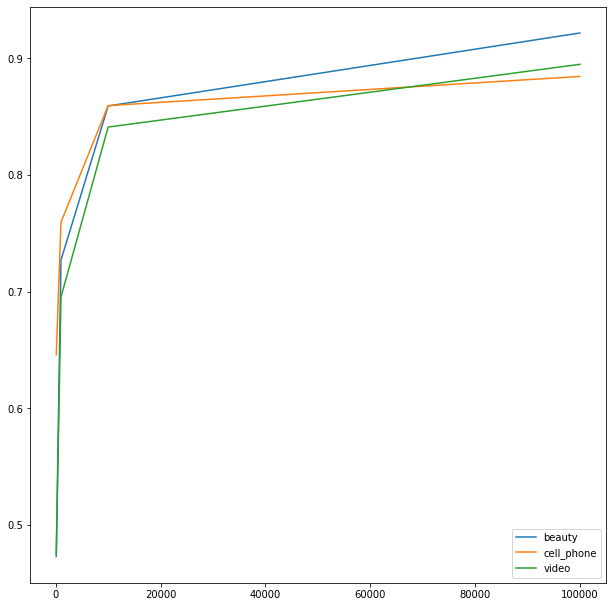

In [196]:
import numpy as np

fig= plt.figure(figsize=(10,10))

axes= fig.add_axes([0.1,0.1,0.8,0.8])

beauty_X = list()
beauty_Y = list()
cell_phone_X = list()
cell_phone_Y = list()
video_X = list()
video_Y = list()
print(len(f1_list['beauty']))
for val in f1_list['beauty']:
    beauty_X.append(val[0])
    beauty_Y.append(val[1])
    
for val in f1_list['cell_phone']:
    cell_phone_X.append(val[0])
    cell_phone_Y.append(val[1])
    
for val in f1_list['video']:
    video_X.append(val[0])
    video_Y.append(val[1])
    
axes.plot(beauty_X, beauty_Y)
axes.plot(cell_phone_X, cell_phone_Y)
axes.plot(video_X, video_Y)
axes.legend(['beauty', 'cell_phone', 'video'], loc='lower right')

plt.show()


### Exercise 2: SVM Ranking

In this exercise, you will compare SVM regression to SVM ranking for predicting fine-grained opinion ratings.

#### 2.1
rubric={accuracy:2,quality:1}

First, do the regression version. Relative to what you did in exercise 1, there are three changes

- adapt the `prepare_for_vectorizer` function to `prepare_for_vectorizer_regression` function which no longer binarizes the data
- change the SVC (support vector classifier) to a SVR (support vector regressor)
- evalute the predicted ranks against the original ranks using Kendall's Tau, not f-score

As usual, run it for all three datasets.

In [9]:
#prepare for vectorizor regression
#prepare for regression
def prepare_for_vectorizer_regression(data):
    '''
    input: Takes a list of reviews 
    output: A list of strings and list of classes 
    '''
    texts = list()
    classes = list()
    for review in data:
        classes.append(review['overall'])
        texts.append(review['summary'] + ' ' + review['reviewText'] )
    
    return texts, classes

def prepare_for_regression(train,test,max_n=2):
    '''convert lists of reviews train and test to spare feature matrices X_train and X_test,
    and lists of binary polarity classifications train_class and test_class'''
    vectorizer = CountVectorizer(ngram_range=(1,max_n),min_df=2)
    train_texts, train_class = prepare_for_vectorizer_regression(train)
    test_texts, test_class = prepare_for_vectorizer_regression(test)
    X_train = vectorizer.fit_transform(train_texts)
    X_test = vectorizer.transform(test_texts)
    return X_train,train_class, X_test,test_class

In [133]:
result = defaultdict(list)
for i in range(len(all_train)):
    X_train, train_class, X_test, test_class = prepare_for_regression(all_train[i], all_test[i], best_n_gram[i])
        
    clf = LinearSVR()
    clf.fit(X_train, train_class)
    prediction = clf.predict(X_test)
    tau, p_value = kendalltau(test_class, prediction)
    result[data[i]].append((tau, p_value))
        
result

defaultdict(list,
            {'beauty': [(0.5259545905347947, 2.5851055387209322e-22)],
             'cell_phone': [(0.4720111000380144, 1.5078874980399432e-18)],
             'video': [(0.35204247246862014, 1.0772592899361658e-10)]})

#### 2.2
rubric={accuracy:3,efficiency:1}

Now, you will implement SVMrank using LinearSVC. The main part is to write a function `convert to pairwise` which converts the normal output of `prepare_for_vectorizer_regression` and turns it into a (pairwise) classification task using the following logic:

- for each original datapoint (feature vector), randomly select one other datapoint that has a different rating (you should keep trying until you get one, don't discard data!)
- create a feature vector which is the difference between the two feature vectors
- create a label which should be 1 if the rating of the first datapoint is larger than the second, or 0 if the second rating is larger

You should return a new feature matrx and the corresponding list of labels. Note that you MUST preserve the sparsity of the feature matrix, these matrices are far too big to be densified.

This will take a while for the 100k datapoints you have in each corpus, and so you should have a counter that shows your progress.

In [156]:
def convert_to_pairwise(data,ratings):
    '''covert a normal collection of data with ordinal ratings into a pairwise classification task
    by randomly choosing one comparison datapoint with a different rating and taking the direction of
    the difference as the class of the new datapoint'''
    # your code here
    count = 0
    pairwise_class = list()
    pairwise_data = list()
    num_of_examples = data.shape[0]
    for i, row in enumerate(data):
        count += 1
        current_row = data[i]
        current_class = ratings[i]
        next_index = np.random.randint(0, num_of_examples)
        while ratings[next_index] == current_class:
            
            next_index = np.random.randint(0, num_of_examples)
        
        next_example = data[next_index]
        difference = current_row - next_example

        if current_class > ratings[next_index]:
            label = 1
        else:
            label = 0
        pairwise_data.append(difference)
        pairwise_class.append(label)

    pairwise_data = vstack(pairwise_data)
    
    return pairwise_data, pairwise_class
                
        

In [113]:
train, test = load_amazon_reviews_no_dups(amazon_review_dir + "reviews_Musical_Instruments_5.json.gz",test_size=200) 
train_features,train_scores, test_features,test_scores = prepare_for_regression(train,test)
pairwise_data, pairwise_class = convert_to_pairwise(train_features,train_scores)
assert pairwise_data.shape == train_features.shape
assert len(set(pairwise_class)) == 2
print("Success!")

Success!


#### 2.3
rubric={accuracy:2}

Use `convert to pairwise` to carry out SVM ranking. Note that although you are converting the training set to pairwise, you don't do this for the test set. Note also that you can't use the `predict` function for the resulting classifier because the result would be a class. Instead, you want the result from taking a dot product of each feature vector and the weights of the SVM classifier (`coef_`). Again, evaluate the performance in the 3 corpora using Kendall's tau. You should get strikingly better results.

In [136]:
prediction = list()
for feature in X_test:
    dot_product = np.sum(feature.multiply(clf.coef_))
    #print(dot_product)

    prediction.append(dot_product)
tau, p_value = kendalltau(test_class, prediction)
print(tau)

0.5931139675123936


In [157]:
# test set should use the 2000
result = dict()
for i in range(len(all_train)):
    prediction = list()
    X_train, train_class, X_test, test_class = prepare_for_regression(all_train[i], all_test[i], best_n_gram[i])
    pairwise_data, pairwise_class = convert_to_pairwise(X_train,train_class)
    clf = LinearSVC()
    clf.fit(pairwise_data, pairwise_class)
    for feature in X_test:
        dot_product = np.sum(feature.multiply(clf.coef_))
        #print(dot_product)

        prediction.append(dot_product)
    tau, p_value = kendalltau(test_class, prediction)
    result[data[i]] = (tau, p_value)
        
result

/Users/chidera/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/chidera/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/chidera/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


{'beauty': (0.5646617167809718, 2.713317398151985e-239),
 'cell_phone': (0.5493441588182651, 2.6247682759398534e-229),
 'video': (0.5170716574294437, 3.884122453122774e-204)}

### Exercise 3: Pollyannas and Negative Nellies
rubric={accuracy:3,quality:1}

In this exercise, we are going to see how well our automated system is able to duplicate the conclusions of a simple kind of "author profiling" based on gold standard ratings. Two functions are provided to you: the first is `load_amazon_reviews_reviewer_groups` (a variation on `load_amazon_reviews_no_dups`) which creates a test set consisting of reviews written by authors with a total of at least 20 reviews; the training set consists of all other reviews.

The second function uses the test set to derive a list of "Pollyannas" and "Negative Nellies". The former is defined as reviewers who have only given five star reviews, and the latter are those reviewers whose average review rating is below 3 (True Negative Nellies, those who only give 1 star reviews, do not seem to exist! The Pollyanna hypothesis at work yet again...).

In [34]:
review_min = 20

def load_amazon_reviews_reviewer_groups(corpus_path,test_size=2000,seed=42):
    '''loads a gzipped amazon review corpus, prepare a test set consisting of reviews whose reviewers
    have at least 20 total reviews, and the training set consisting of all other reviews'''
    g = gzip.open(corpus_path, 'r')
    all_reviews = [eval(line) for line in g]
    random.seed(seed)
    random.shuffle(all_reviews)
    train_set = []
    test_set = []
    reviewer_groups = defaultdict(list)
    for i,review in enumerate(all_reviews):
        reviewer_groups[review["reviewerID"]].append(review)
    for reviewer_group in reviewer_groups.values():
        if len(reviewer_group) > review_min:
            for review in reviewer_group:
                test_set.append(review)
        else:
            train_set.extend(reviewer_group)
        
    return train_set,test_set


def get_pollyannas_and_nellies(reviews):
    '''get a list of pollyannas (reviewers with only 5 star reviews) and negative nellies (those
    whose average rating is negative) based on the list of reviews'''
    reviewer_ratings = defaultdict(list)
    nellies = set()
    pollyannas = set()
    for review in reviews:
        reviewer_ratings[review["reviewerID"]].append(review["overall"])
    for reviewer,ratings in reviewer_ratings.items():
        avg = sum(ratings)/len(ratings)
        if avg < 3:
            nellies.add(reviewer)
        if avg == 5:
            pollyannas.add(reviewer)
    return pollyannas,nellies

Use the SVM ranking approach from exercise 2 to derived automatic ratings to the reviews for all reviewers with at least 20 reviews (i.e. the test set provided by `load_amazon_reviews_reviewer_groups`). Then use these ratings to rank the reviewers by the average positivity of their reviews, and see what percentage of the gold standard "Nellies" (as identified by `get_pollyannas_and_nellies`) are in the bottom 20% in terms of (automatically-determined) average positivity, and what percentage of gold standard "Pollyannas" are in the top 20%. A high score indicates that we are more or less able to re-identify reviewers with strongly positive and negative biases using only automatically-generated review scores.

In [160]:
beauty_train, beauty_test = load_amazon_reviews_reviewer_groups(amazon_review_dir + "reviews_Beauty_5.json.gz")
cell_phone_train, cell_phone_test = load_amazon_reviews_reviewer_groups(amazon_review_dir + "reviews_Cell_Phones_and_Accessories_5.json.gz")
video_train, video_test = load_amazon_reviews_reviewer_groups(amazon_review_dir + "reviews_Video_Games_5.json.gz")

In [161]:
review_group_train = [beauty_train, cell_phone_train, video_train]
review_group_test = [beauty_test, cell_phone_test, video_test]

In [167]:
all_data = list()
for i in range(len(review_group_train)):
    review_rank = defaultdict(list)
    prediction = list()
    sorted_rev = dict()
    X_train, train_class, X_test, test_class = prepare_for_regression(review_group_train[i], review_group_test[i], best_n_gram[i])
    pairwise_data, pairwise_class = convert_to_pairwise(X_train,train_class)
    clf = LinearSVC()
    clf.fit(pairwise_data, pairwise_class)
    for j in range(len(test_class)):
        dot_product = np.sum(X_test[j].multiply(clf.coef_))
        review_rank[review_group_test[i][j]['reviewerID']].append(dot_product)
    
    
    ## Sorting the reviews 
    for review in review_rank:
        sorted_rev[review] = sum(review_rank[review])/len(review_rank[review])
    sort_review = sorted(sorted_rev, key=sorted_rev.get)
    ratio = len(sort_review) * 0.2
    pred_polyannas = sort_review[-int(ratio):]
    pred_nellies = sort_review[:int(ratio)]
    
    ### Evaluation for polyannas 
    correct = 0
    gold_polyannas, gold_nellies = get_pollyannas_and_nellies(review_group_test[i])
    for poly in pred_polyannas:
        if poly in gold_polyannas:
            correct += 1
    poly_accuracy = correct/len(gold_polyannas)
    print(data[i], " Polyanna accuracy: ", poly_accuracy)
    print('**************')
    
    ### Evaluation for nellies 
    correct = 0

    for nellie in pred_nellies:
        if nellie in gold_nellies:
            correct += 1
    nellie_accuracy = correct/len(gold_nellies)
    print(data[i], " Nellies accuracy: ", nellie_accuracy)
    
    print('**************')


/Users/chidera/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


beauty  Polyanna accuracy:  0.8813559322033898
**************
beauty  Nellies accuracy:  0.95
**************


/Users/chidera/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


cell_phone  Polyanna accuracy:  0.5714285714285714
**************
cell_phone  Nellies accuracy:  1.0
**************


/Users/chidera/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


video  Polyanna accuracy:  0.625
**************
video  Nellies accuracy:  0.8596491228070176
**************


### Exercise 4: Sarcasm hunt (Optional)
rubric={accuracy:1}

Use some automatic method to find sarcasm in the Amazon Review corpus. You can use any method EXCEPT looking for explicit mentions of the word sarcasm (or related words). It's okay if you have to do some manual checking, but your automatic approach should greatly narrow it down. You can get most of the points in this problem if you find at least one, but for full points you should find more, at least 5.